In [121]:
import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from talib import  BBANDS, ROC, EMA, MACD
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import  plot_pacf, plot_acf
#from datetime import datetime

data_dir = 'data'

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]

# Initialize an empty list to store DataFrames
df_list = []

# Read each JSON file and append the DataFrame to the list
for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    df = pd.read_json(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df_org = pd.concat(df_list, ignore_index=True)


def compute_average_ask_bid(price_data):
    if( price_data['Ask'] is not None and price_data['Bid'] is not None):
        return (price_data['Ask'] + price_data['Bid']) / 2
    else:
        return None

df_org['openPrices'] = [compute_average_ask_bid(OpenPrice) for OpenPrice in df_org["OpenPrice"]];
df_org['highPrices'] = [compute_average_ask_bid(HighPrice) for HighPrice in df_org["HighPrice"]];
df_org['lowPrices'] = [compute_average_ask_bid(LowPrice) for LowPrice in df_org["LowPrice"]];
df_org['closedprices'] = [compute_average_ask_bid(closedprice) for closedprice in df_org["ClosePrice"]];

## Drop rows with None values
df_org.dropna(subset=['closedprices', 'highPrices', 'lowPrices', 'openPrices'], inplace=True)


# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['closedprices'] / df_org['closedprices'].shift(1))
df_org['forward_returns'] = df_org['log_returns'].shift(-1)
df_org['momentum'] = np.log(df_org['closedprices']/df_org['closedprices'].shift(20))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

# Extract unique days
df_org['Date'] = df_org['SnapshotTime'].dt.date
unique_days = df_org['Date'].unique()

up, mid, low = BBANDS(df_org.closedprices, timeperiod=21, nbdevup=1.5, nbdevdn=1.5, matype=0)
roc10= ROC(df_org.closedprices, timeperiod=10 )
roc13= ROC(df_org.closedprices, timeperiod=13 )
roc15= ROC(df_org.closedprices, timeperiod=15 )
roc20= ROC(df_org.closedprices, timeperiod=20 )



In [122]:
up, mid, low = BBANDS(df_org.closedprices, timeperiod=21, nbdevup=1.5, nbdevdn=1.5, matype=0)
roc10= ROC(df_org.closedprices, timeperiod=10 )
roc13= ROC(df_org.closedprices, timeperiod=13 )
roc15= ROC(df_org.closedprices, timeperiod=15 )
roc20= ROC(df_org.closedprices, timeperiod=20 )
kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)

roc300= ROC(df_org.closedprices, timeperiod=50 )
roc400= ROC(df_org.closedprices, timeperiod=100 )
roc600= ROC(df_org.closedprices, timeperiod=150 )
roc800= ROC(df_org.closedprices, timeperiod=200 )
kstlt = 1.618 * EMA(roc300, 30) +  1.5*EMA(roc400,40) +  1.382 * EMA(roc600,60) + 1.236*EMA(roc800,80)

df_org['kstmt'] = kstmt 
df_org['kstlt'] = kstlt

df_org.dropna(subset=['kstmt', 'kstlt'], inplace=True)

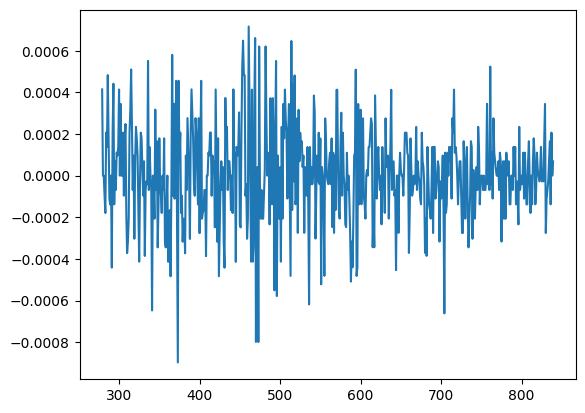

In [123]:
split_date = datetime(2024, 11, 18).date()
df_fit= df_org.loc[df_org['Date'] <= split_date]
plt.plot(df_fit['log_returns'])

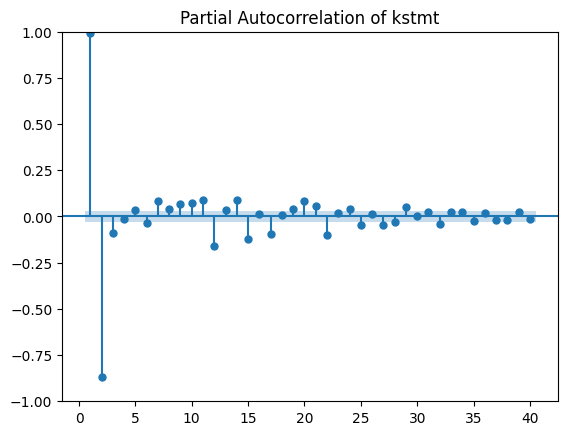

In [128]:
fig, ax = plt.subplots()


plot_pacf(df_org['kstmt'], ax=ax, method='ywm', lags=40, alpha=0.0001, use_vlines=True, title='Partial Autocorrelation of kstmt', zero=False)
#ax.set_ylim(-0.25, 0.25)

plt.show()